In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import pickle
from sklearn.metrics import mean_squared_error

In [20]:
#path=""
#data = pd.read_csv(path)
from google.colab import drive
drive.mount('/content/drive')
# Load the file from Google Drive
data = pd.read_csv("/content/drive/MyDrive/Datasets - Colab/file_name.csv")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [21]:
#checking columns
data.columns

Index(['Date', 'PS', 'PSC', 'T2M', 'T2MWET', 'T2MDEW'], dtype='object')

In [22]:
data.drop(["PS", "PSC", "T2MWET", "T2MDEW"], axis=1, inplace=True)

In [23]:
data.head(20)

,Date,T2M
0,2004010105,17.09
1,2004010106,16.89
2,2004010107,18.99
3,2004010108,22.87
4,2004010109,26.31
5,2004010110,28.72
6,2004010111,30.14
7,2004010112,30.95
8,2004010113,31.21
9,2004010114,30.86


In [24]:
#Dropping the first 19 rows from the main DataFrame as it is incomplete for that particular day
data=data.iloc[19:]

In [25]:
data.head()

,Date,T2M
19,2004010200,16.10
20,2004010201,15.61
21,2004010202,15.19
22,2004010203,14.87
23,2004010204,14.62


In [26]:
data.tail()

,Date,T2M
175315,2014010100,18.12
175316,2014010101,17.73
175317,2014010102,17.44
175318,2014010103,17.23
175319,2014010104,17.12


In [27]:
# Drop the last 5 rows from the main DataFrame as it is incomplete for that particular day
data = data.iloc[:-5]

In [28]:
data.tail()

,Date,T2M
175310,2013123119,21.25
175311,2013123120,20.50
175312,2013123121,19.82
175313,2013123122,19.19
175314,2013123123,18.61


In [29]:
# convert the date column to datetime format
data['Date'] = pd.to_datetime(data['Date'], format='%Y%m%d%H')

# print the resulting DataFrame
print(data)

                      Date    T2M
19     2004-01-02 00:00:00  16.10
20     2004-01-02 01:00:00  15.61
21     2004-01-02 02:00:00  15.19
22     2004-01-02 03:00:00  14.87
23     2004-01-02 04:00:00  14.62
...                    ...    ...
175310 2013-12-31 19:00:00  21.25
175311 2013-12-31 20:00:00  20.50
175312 2013-12-31 21:00:00  19.82
175313 2013-12-31 22:00:00  19.19
175314 2013-12-31 23:00:00  18.61

[175296 rows x 2 columns]


In [30]:
data.index = data['Date']

In [31]:
data=data.sort_index()

In [32]:
data.head()

,Date,T2M
Date,,
2004-01-02 00:00:00,2004-01-02 00:00:00,16.10
2004-01-02 01:00:00,2004-01-02 01:00:00,15.61
2004-01-02 02:00:00,2004-01-02 02:00:00,15.19
2004-01-02 03:00:00,2004-01-02 03:00:00,14.87
2004-01-02 04:00:00,2004-01-02 04:00:00,14.62


In [33]:
#Renaming columns
data.rename(columns={'T2M': 'TEMP'}, inplace=True)

In [34]:
data.count()

Date    175296
TEMP    175296
dtype: int64

In [35]:
# Splitting data into train and test sets
train_data = data[:-96]  # Use all data except the last 48 hours for training
test_data = data[-96:]   # Use the last 48 hours for testing

In [36]:
# SARIMA model parameters
order = (1, 1, 1)  # ARIMA parameters (p, d, q)
seasonal_order = (1, 1, 1, 24)  # SARIMA parameters (P, D, Q, S)

In [37]:
check=train_data[:8760] #1 year data
test=train_data[8760:8808] #2 days = 48 hours

In [39]:
# Fit SARIMA model
mumbai_model = SARIMAX(check["TEMP"], order=order, seasonal_order=seasonal_order, enforce_stationarity=False, enforce_invertibility=False, dates=check["Date"])
mumbai_result = mumbai_model.fit()

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)


In [40]:
# Forecast temperatures for the next 48 hours
forecast = mumbai_result.get_forecast(steps=48)

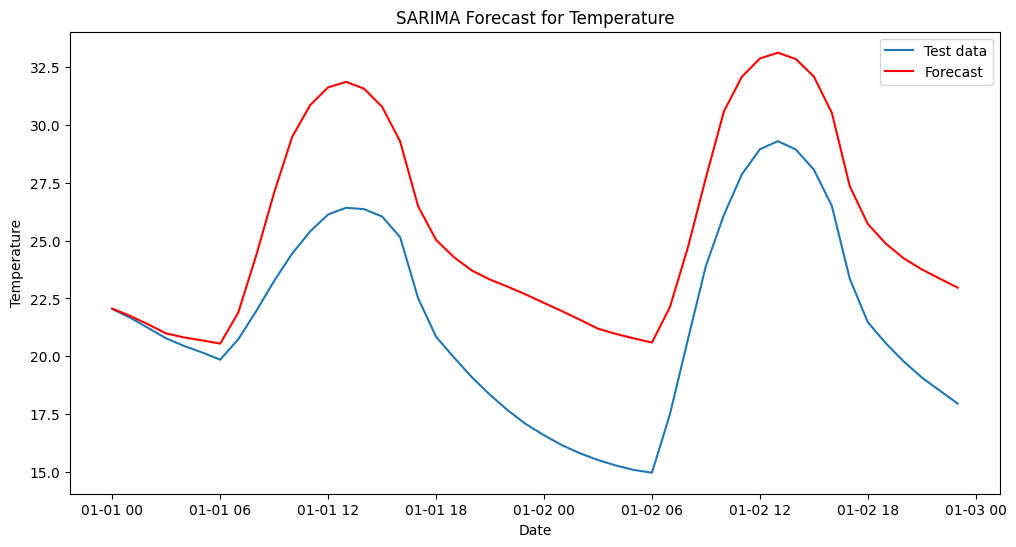

In [41]:
# Plot the predicted values along with the actual values
plt.figure(figsize=(12, 6))
#plt.plot(check.index, check["TEMP"], label='Train data')
plt.plot(test.index, test["TEMP"], label='Test data')
plt.plot(forecast.predicted_mean, label='Forecast', color='red')
#plt.plot(forecast.index, forecast.predicted_mean, label='Forecast', color='red')
#plt.fill_between(forecast.index, forecast_ci.iloc[:, 0], forecast_ci.iloc[:, 1], color='pink', alpha=0.5)
plt.title('SARIMA Forecast for Temperature')
plt.xlabel('Date')
plt.ylabel('Temperature')
plt.legend()
plt.show()

In [42]:
rmse = np.sqrt(mean_squared_error(test["TEMP"], forecast.predicted_mean))
print(f'Root Mean Squared Error (RMSE): {rmse}')

Root Mean Squared Error (RMSE): 4.335337459845152


In [43]:
#saving pickle file of model
with open("/content/drive/MyDrive/Datasets - Colab/mumbai_model.pkl", 'wb') as f:
    pickle.dump(mumbai_result, f)

In [ ]:
# Load the saved SARIMA model from the file
with open("/content/drive/MyDrive/Datasets - Colab/mumbai_model.pkl", 'rb') as f:
   mumbai_result = pickle.load(f)

In [44]:
table=[8760*x for x in range(1, 21)]
table

[8760,
 17520,
 26280,
 35040,
 43800,
 52560,
 61320,
 70080,
 78840,
 87600,
 96360,
 105120,
 113880,
 122640,
 131400,
 140160,
 148920,
 157680,
 166440,
 175200]

In [54]:
i=4
check2=train_data[table[i-2]:table[i-1]]
test2=train_data[table[i-1]:table[i-1]+48] #2 days = 48 hours
print("training now: ", i)

training now:  4


In [55]:
mumbai_result=mumbai_result.extend(check2["TEMP"])

In [ ]:
with open("/content/drive/MyDrive/Datasets - Colab/mumbai_model.pkl", 'wb') as f:
    pickle.dump(mumbai_result, f)

In [51]:
# Forecast temperatures for the next 48 hours
forecast2 = mumbai_result.get_forecast(steps=48)

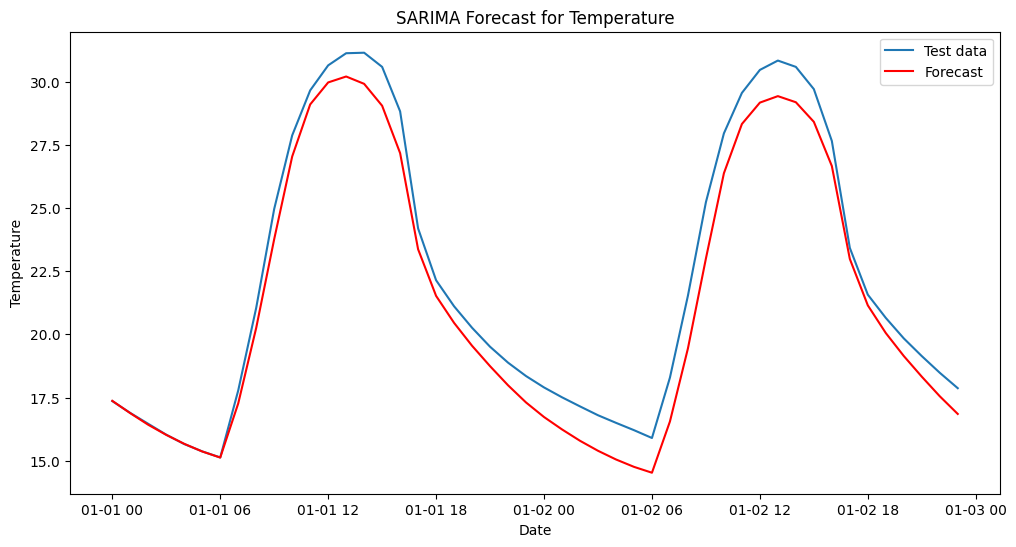

In [52]:
# Plot the predicted values along with the actual values
plt.figure(figsize=(12, 6))
#plt.plot(check.index, check["TEMP"], label='Train data')
plt.plot(test2.index, test2["TEMP"], label='Test data')
plt.plot(forecast2.predicted_mean, label='Forecast', color='red')
#plt.plot(forecast.index, forecast.predicted_mean, label='Forecast', color='red')
#plt.fill_between(forecast.index, forecast_ci.iloc[:, 0], forecast_ci.iloc[:, 1], color='pink', alpha=0.5)
plt.title('SARIMA Forecast for Temperature')
plt.xlabel('Date')
plt.ylabel('Temperature')
plt.legend()
plt.show()

In [53]:
rmse = np.sqrt(mean_squared_error(test2["TEMP"], forecast2.predicted_mean))
print(f'Root Mean Squared Error (RMSE): {rmse}')

Root Mean Squared Error (RMSE): 1.0898718171656763
